# Aumented data 

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import cv2
import os
import ast
import albumentations as A
from tqdm import tqdm

c:\Users\GIGABYTE\anaconda3\envs\yolo\lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.6 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Organize Folders and Filenames

In [2]:
# images are labeled and all files name have sequential name

# Load image


In [2]:
image = cv2.imread('D:/install/AI/Code/Project/yolo/V8/Yolov8/data_collect/images/A1.jpg')


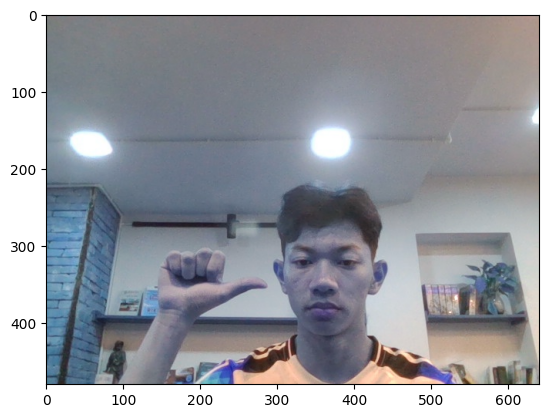

In [3]:
plt.imshow(image)

In [4]:
image.shape

(480, 640, 3)

In [5]:
load_bboxes = np.genfromtxt('D:/install/AI/Code/Project/yolo/V8/Yolov8/data_collect/labels/A1.txt')
load_bboxes = list(load_bboxes)
bbox_cat = int(load_bboxes[0])
bboxes = load_bboxes[1:]
bboxes

[0.339062, 0.728125, 0.23125, 0.20625]

In [6]:
bbox_cat

0

In [7]:
load_bboxes

[0.0, 0.339062, 0.728125, 0.23125, 0.20625]

In [8]:
# Image info
img_ht = int(image.shape[0])
img_wd = int(image.shape[1])
bb_width = int(round(bboxes[2] * image.shape[1], 0))
bb_height = int(round(bboxes[3] * image.shape[0], 0))

print(f'Image height: {img_ht}')
print(f'Image width: {img_wd}')
print(f'Bbox height: {bb_height}')
print(f'Bbox width: {bb_width}')

Image height: 480
Image width: 640
Bbox height: 99
Bbox width: 148


In [9]:
# pascal_voc format 
x_min = int((img_wd * bboxes[0]) - (bb_width/2))
x_max = int((img_wd * bboxes[0]) + (bb_width/2))
y_min = int(img_ht * bboxes[1] - (bb_height/2))
y_max = int(img_ht * bboxes[1] + (bb_height/2))
new_bboxes = [x_min, y_min, x_max, y_max]
print(f'Bbox x_min: {x_min}')
print(f'Bbox x_max: {x_max}')
print(f'Bbox y_min: {y_min}')
print(f'Bbox y_max: {y_max}')
print(f'new_bboxes: {new_bboxes}')

Bbox x_min: 142
Bbox x_max: 290
Bbox y_min: 300
Bbox y_max: 399
new_bboxes: [142, 300, 290, 399]


# Show image and Bounding Box Function

In [10]:

category_id_to_name = {0: 'A', 
                       1: 'B',
                       2: 'C', 
                       3: 'D',
                       4: 'DD', 
                       5: 'E',
                       6: 'G', 
                       7: 'H',
                       8: 'I', 
                       9: 'K',
                       10: 'L',
                       11: 'M',
                       12: 'N',
                       13: 'O',
                       14: 'P',
                       15: 'Q',
                       16: 'R',
                       17: 'S',
                       18: 'T',
                       19: 'U',
                       20: 'V',
                       21: 'X',
                       22: 'Y',
                       }
BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (255, 255, 255) # White

def show_image(image, bbox, bbox_cat, category_id_to_name):
    class_name = category_id_to_name[bbox_cat]
    image = visualize_bbox(image.copy(), bbox, class_name)
    f = plt.figure(figsize=(10,10))
    plt.imshow(
        cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
        interpolation='nearest'
    )
    plt.axis('off')
    f.tight_layout()
    plt.show()
    
def visualize_bbox(image, bbox, class_name, color=BOX_COLOR, thickness=1):
    x_min, y_min, x_max, y_max = map(lambda v: int(v), bbox)
    
    cv2.rectangle(
        image,
        (x_min, y_min),
        (x_max, y_max),
        color=color,
        thickness=thickness
    )
        
    
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 2.7, 2)    
    cv2.rectangle(image, (x_min, y_min - int(1.2 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        image,
        text= category_id_to_name[bbox_cat],
        org=(x_min, y_min - int(.1 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=2.35, 
        color=TEXT_COLOR,
        thickness=3,
        lineType=cv2.LINE_AA,
    )
    return image



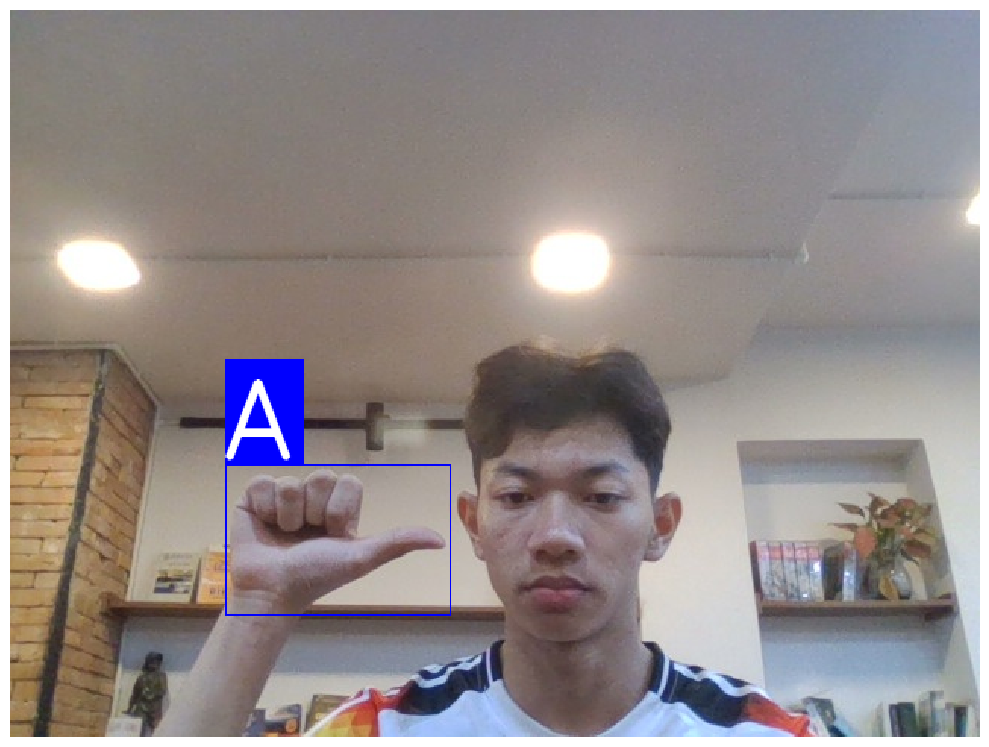

In [11]:
show_image(image, new_bboxes, bbox_cat, category_id_to_name)

In [12]:
def show_augmented(augmentation, image, bbox, class_name):
    augmented = augmentation(image=image, bboxes=[bbox], class_name=[class_name])
    show_image(augmented['image'], augmented['bboxes'][0], bbox_cat, category_id_to_name)

In [13]:
# [x_min, y_min, x_max, y_max]
bbox_params = A.BboxParams(
    format= 'pascal_voc',
    min_area=1,
    min_visibility=0.5,
    label_fields=['class_name']
)

In [14]:
# Source: https://github.com/albumentations-team/albumentations_examples/blob/master/notebooks/example_bboxes.ipynb
aug = A.Compose([
    A.LongestMaxSize(max_size=640),  # Đảm bảo kích thước ảnh tối đa là 640
    A.PadIfNeeded(min_height=480, min_width=640, border_mode=0,value=(0, 0, 0), p=1.0),  # Padding cho đúng 480x640
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.15, rotate_limit=20, p=0.3),  # Giảm dịch chuyển, xoay
    A.RandomSizedCrop((380, 440), 480, 640, p=0.2),  # Giữ crop gần với khung hình
    A.HorizontalFlip(p=.5),
    A.Rotate(limit=20,p=.8),
    A.MultiplicativeNoise(p=.2),
    A.RGBShift(r_shift_limit=30, g_shift_limit=30, b_shift_limit=30, p=0.3),
    A.Blur(blur_limit=25, p=0.2),  # Giảm độ mờ
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.25, p=0.5),
    A.HueSaturationValue(p=.3),
    A.CoarseDropout(max_holes=6, min_width=20, max_width=100, min_height=20, max_height=100, p=0.2),  # Giảm kích thước dropout
    A.OneOf([A.GaussNoise(var_limit=(10, 30), mean=30)], p=0.2),
    A.OneOf([
        A.MotionBlur(p=0.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.Blur(blur_limit=3, p=0.1)], p=0.2),
    A.OneOf([A.Sharpen(),
         A.Emboss(),
         A.RandomBrightnessContrast(),
         A.RandomGamma(gamma_limit=[80,150], p=.2),
         A.ToGray()], p=0.3),
]
    , bbox_params=bbox_params)


In [15]:
class_name = bbox_cat

In [16]:
class_name

0

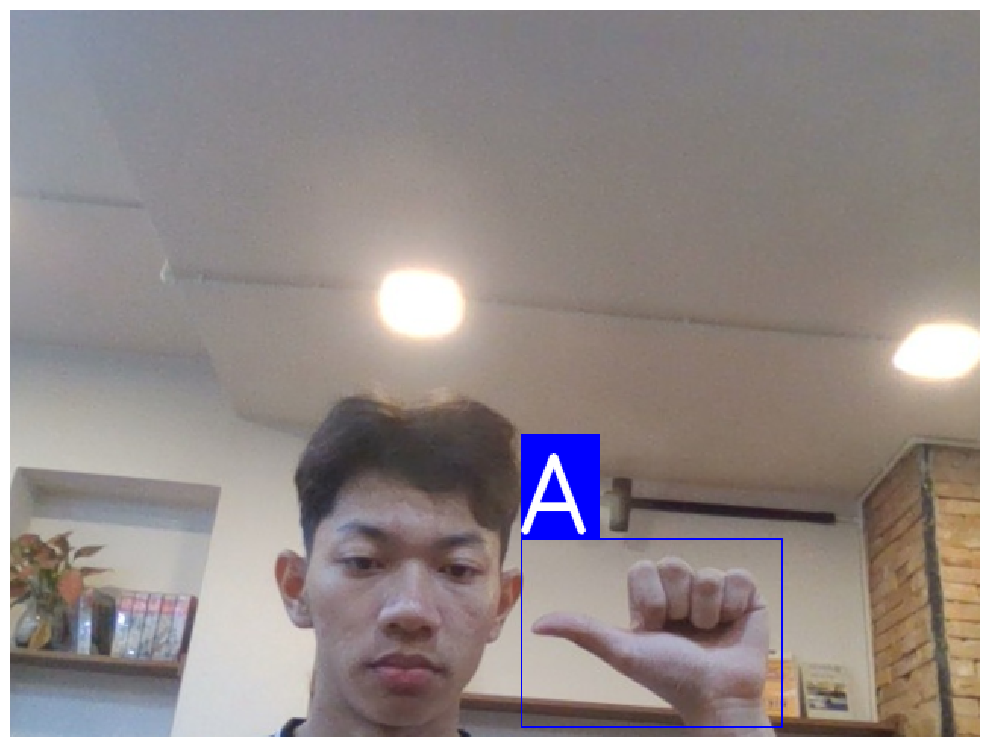

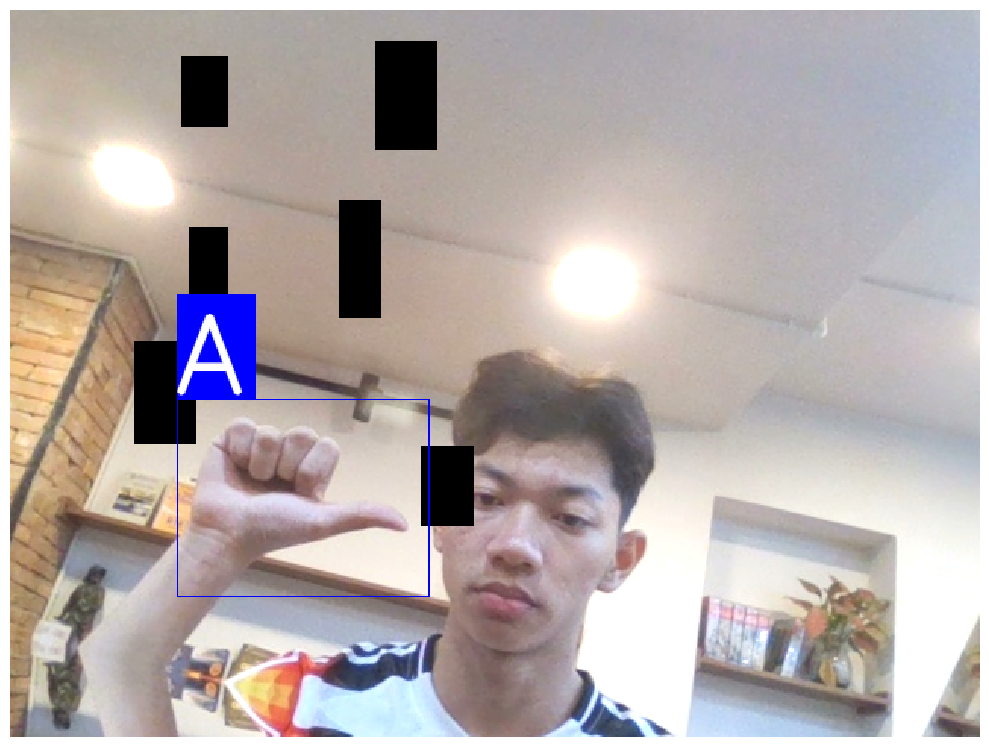

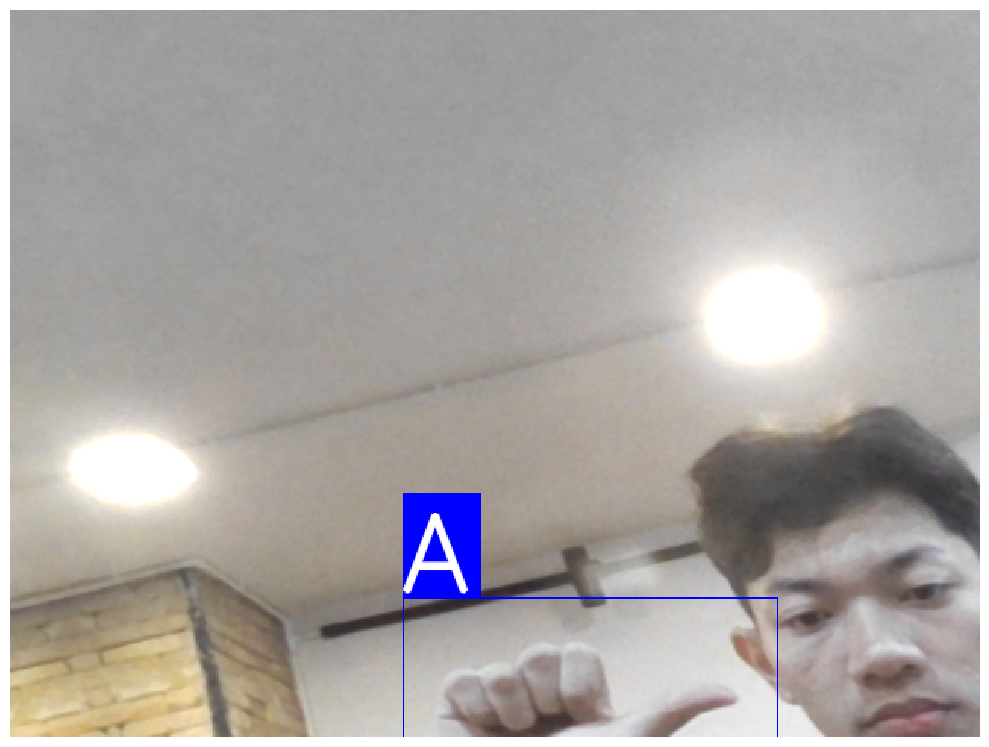

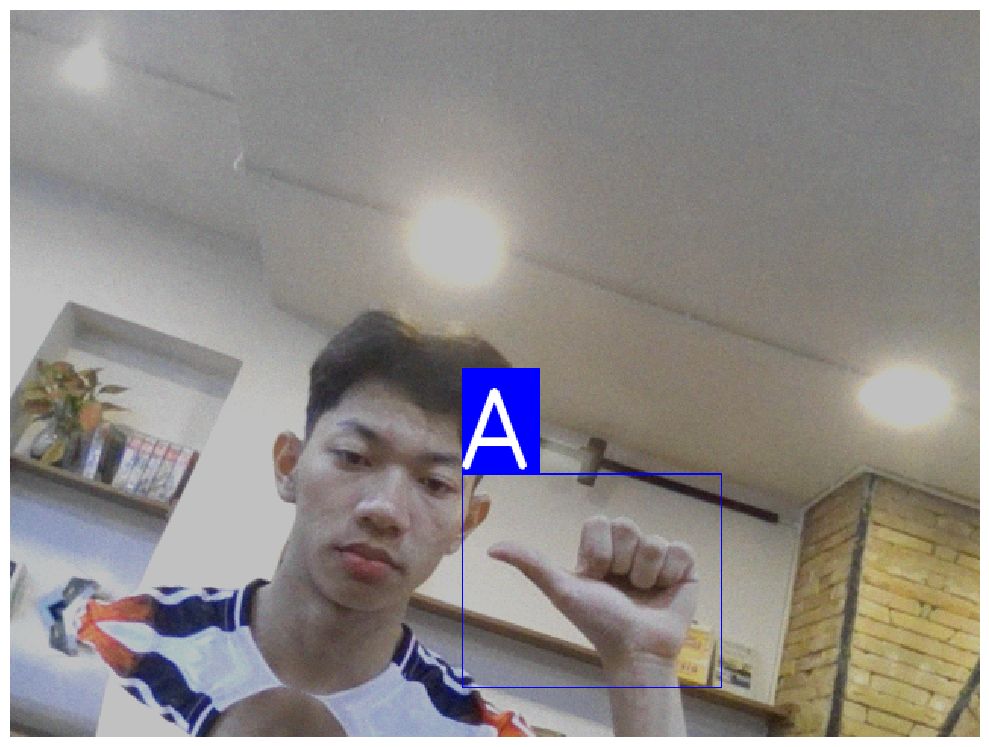

In [17]:
for i in range(4):
    show_augmented(aug, image, new_bboxes, class_name)

In [56]:
path_sign_language_letter_request = 'D:\install\AI\Code\Project\yolo\V8\Yolov8\data_collect\images'
path_labels = 'D:\install\AI\Code\Project\yolo\V8\Yolov8\data_collect\labels'
DATASET_PATH = 'D:\install\AI\Code\Project\yolo\V8\Yolov8\aug_data'
IMAGES_PATH = f'{DATASET_PATH}/images'
for filename in os.listdir(path_sign_language_letter_request):
        image_path = os.path.join(path_sign_language_letter_request, filename)
        print(image_path)
        load_bboxes = np.genfromtxt(path_labels+'/'+filename[:-4] + '.txt')
        print(load_bboxes)
        load_bboxes = list(load_bboxes)
        print(load_bboxes)
        bbox_cat = int(load_bboxes[0])
        bboxes = load_bboxes[1:]
        img_ht = int(image.shape[0])
        img_wd = int(image.shape[1])
        bb_width = int(round(bboxes[2] * image.shape[1], 0))
        bb_height = int(round(bboxes[3] * image.shape[0], 0))

        x_min = int((img_wd * bboxes[0]) - (bb_width/2))
        x_max = int((img_wd * bboxes[0]) + (bb_width/2))
        y_min = int(img_ht * bboxes[1] - (bb_height/2))
        y_max = int(img_ht * bboxes[1] + (bb_height/2))
        new_bboxes = [x_min, y_min, x_max, y_max]
        print(new_bboxes)
        break

D:\install\AI\Code\Project\yolo\V8\Yolov8\data_collect\images\A1.jpg
[0.       0.339062 0.728125 0.23125  0.20625 ]
[0.0, 0.339062, 0.728125, 0.23125, 0.20625]
[142, 300, 290, 399]


# Creating Augmented Dataset


In [25]:
path_sign_language_letter_request = 'D:/install/AI/Code/Project/yolo/V8/Yolov8/data_collect/split_data/train/images'
path_labels = 'D:/install/AI/Code/Project/yolo/V8/Yolov8/data_collect/split_data/train/labels'
DATASET_PATH = 'D:/install/AI/Code/Project/yolo/V8/Yolov8/aug_data'
IMAGES_PATH = f'{DATASET_PATH}/images'
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(IMAGES_PATH, exist_ok=True)

rows = []
for filename in os.listdir(path_sign_language_letter_request):
        image_path = os.path.join(path_sign_language_letter_request, filename)
        image = cv2.imread(image_path)
        load_bboxes = np.genfromtxt(path_labels+'/'+filename[:-4] + '.txt')
        load_bboxes = list(load_bboxes)
        bbox_cat = int(load_bboxes[0])
        bboxes = load_bboxes[1:]
        img_ht = int(image.shape[0])
        img_wd = int(image.shape[1])
        bb_width = int(round(bboxes[2] * image.shape[1], 0))
        bb_height = int(round(bboxes[3] * image.shape[0], 0))

        x_min = int((img_wd * bboxes[0]) - (bb_width/2))
        x_max = int((img_wd * bboxes[0]) + (bb_width/2))
        y_min = int(img_ht * bboxes[1] - (bb_height/2))
        y_max = int(img_ht * bboxes[1] + (bb_height/2))
        new_bboxes = [x_min, y_min, x_max, y_max]


        # Creating 25 augmented images to compensate for the small dataset
        for i in range(1 + 1):  # N là số ảnh augment muốn tạo, +1 để giữ ảnh gốc
            if i == 0:
                # Ảnh gốc (không augment)
                image_aug = image.copy()
                bboxes_aug = [new_bboxes]
            else:
                # Ảnh augment
                augmented = aug(image=image, bboxes=[new_bboxes], class_name=[bbox_cat])
                image_aug = augmented['image']
                bboxes_aug = augmented['bboxes']
            if not bboxes_aug:
                continue

            file_name = f'{filename[:-4]}_{i}.jpg'

            for bbox in bboxes_aug:
                x_min, y_min, x_max, y_max = map(int, bbox)

                # Convert to YOLO format
                x_center = (x_min + x_max) / 2 / 640
                y_center = (y_min + y_max) / 2 / 480
                w = (x_max - x_min) / 640
                h = (y_max - y_min) / 480
                new_bbox = [bbox_cat, x_center, y_center, w, h]

                rows.append({
                    'image_id': file_name,
                    'bbox': new_bbox
                })

            cv2.imwrite(f'{IMAGES_PATH}/{file_name}', image_aug)


# Appending bbox data to new annotation.csv file 
pd.DataFrame(rows).to_csv(f'{DATASET_PATH}/annotations.csv', header=True, index=None)

# Verify augmented images and bounding boxes match

In [64]:
image1 = cv2.imread('D:/install/AI/Code/Project/yolo/V8/Yolov8/aug_data/images/A1_0.jpg')

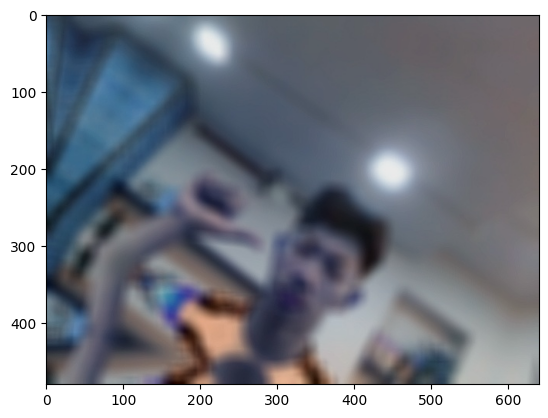

In [65]:
plt.imshow(image1)

In [85]:
image1.shape

(480, 640, 3)

In [99]:
df = pd.read_csv('D:/install/AI/Code/Project/yolo/V8/Yolov8/aug_data/annotations.csv')
df.head()

image_id                                               bbox
0  A1_0.jpg  [0, 0.35859375, 0.5489583333333333, 0.2984375,...
1  A1_1.jpg  [0, 0.3046875, 0.6770833333333334, 0.259375, 0...
2  A1_2.jpg            [0, 0.3375, 0.728125, 0.23125, 0.20625]
3  A1_3.jpg  [0, 0.315625, 0.6958333333333333, 0.25, 0.2458...
4  A1_4.jpg  [0, 0.31875, 0.7010416666666667, 0.246875, 0.2...

In [100]:
# Convert string to list
df.bbox = df.bbox.apply(ast.literal_eval)

In [101]:
new_bboxes1 = df['bbox'][0][1:]

In [102]:
new_bboxes1

[0.35859375, 0.5489583333333333, 0.2984375, 0.3645833333333333]

In [103]:
bbox_cat1 = df['bbox'][0][0]
bbox_cat1

0

In [104]:
# Converting bbox to pascal_voc format
x_min = int((640 * new_bboxes1[0]) - ((new_bboxes1[2]*640)/2))
x_max = int((640 * new_bboxes1[0]) + ((new_bboxes1[2]*640)/2))
y_min = int(480 * new_bboxes1[1] - ((new_bboxes1[3]*480)/2))
y_max = int(480 * new_bboxes1[1] + ((new_bboxes1[3]*480)/2))
new_bboxes1 = [x_min, y_min, x_max, y_max]

In [105]:
new_bboxes1  

[134, 176, 325, 351]

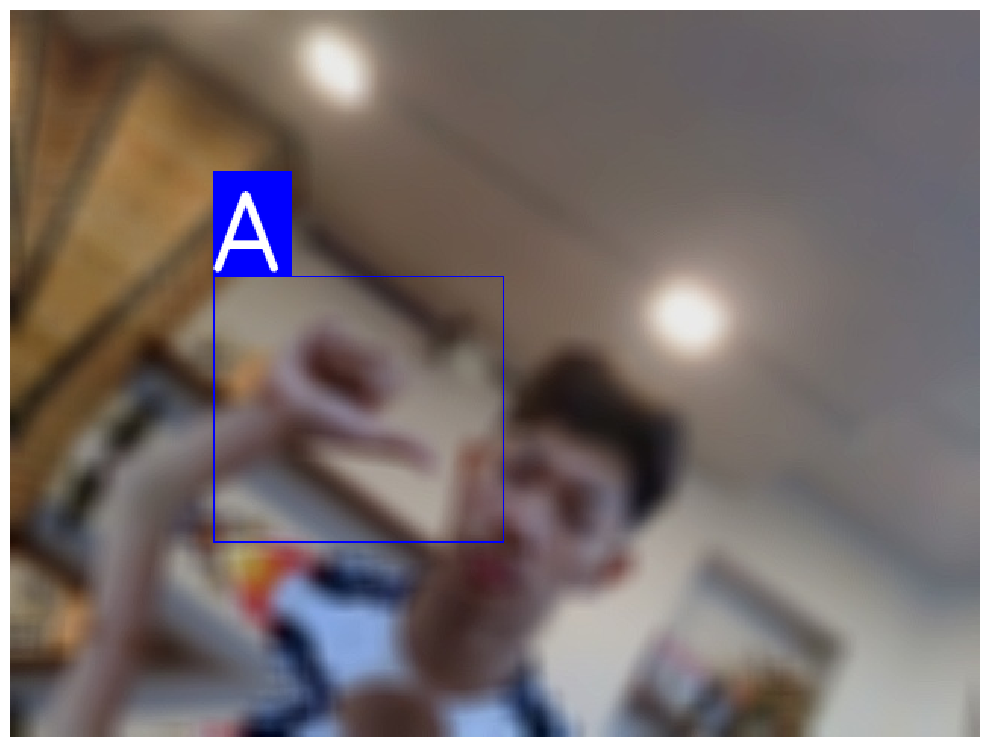

In [106]:
show_image(image1, new_bboxes1, bbox_cat1, category_id_to_name)